In [189]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from random import randint
from math import ceil

from sklearn.linear_model import LogisticRegression

from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import MDS

In [2]:
df_train = pd.read_csv("df_train_processed.csv")
df_test = pd.read_csv("df_test_processed.csv")

In [3]:
df_train = df_train.drop(columns=['actor'])
df_test = df_test.drop(columns=['actor'])

In [4]:
df_train_num = df_train.select_dtypes(include="number")
df_test_num = df_test.select_dtypes(include="number")

## Standardization

In [5]:
scaler = MinMaxScaler()
df_train_num_scal = scaler.fit_transform(df_train_num)
df_test_num_scal = scaler.fit_transform(df_test_num)
df_train_num = pd.DataFrame(df_train_num_scal, columns=df_train_num.columns)
df_test_num = pd.DataFrame(df_test_num_scal, columns=df_test_num.columns)

In [6]:
def add_target_column(df1, df2, target):
    
    df2[target] = df1[target]
    
    return df2

In [7]:
df_final_train = add_target_column(df_train, df_train_num, 'vocal_channel')
df_final_test = add_target_column(df_test, df_test_num, 'vocal_channel')

In [8]:
def lablel_encoder(data, target):
    
    label_encoder = preprocessing.LabelEncoder()
    
    data[target]= label_encoder.fit_transform(data[target])
    
    return data

In [9]:
def spearman_selector(target, df, k):
    """Returns a df comprising all the features highly correlated (above k and below -k)
    with the binary target according Spearman coefficient. Target must be a pd Series"""
    df = df.select_dtypes(include="number")
    target = target.map({target.unique()[0]:0, target.unique()[1]:1})
    new_df = pd.DataFrame()
    for col in df:
        spearman = sp.spearmanr(df[col], target)[0]
        if spearman > k or spearman < -k:
            new_df[col] = df[col]
    return new_df

In [10]:
df_vocal_channel_train = spearman_selector(df_final_train['vocal_channel'], df_final_train, 0.5)

/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [11]:
df_vocal_channel_train = add_target_column(df_final_train, df_vocal_channel_train, 'vocal_channel')

In [12]:
label_encoder = lablel_encoder(df_vocal_channel_train, 'vocal_channel')

In [13]:
columns_in_train = list(df_vocal_channel_train.columns)

In [14]:
df_vocal_channel_test = df_final_test[columns_in_train]

In [15]:
label_encoder = lablel_encoder(df_vocal_channel_test, 'vocal_channel')

<ipython-input-8-4332eac943b7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target]= label_encoder.fit_transform(data[target])


## Rendere training e test datasets imbalanced

In [16]:
def dip_indp_variables(data,target):
    
    X = np.array(data.loc[:, data.columns != target])
    
    y = np.array(data.loc[:, data.columns == target])
    
    result = np.unique(y, return_counts=True)
    
    return  {'X': X,
             'y': y,
             'result': { result[0][0] : result[1][0],
                       result[0][1] : result[1][1]}
           }

In [17]:
dip_indp_variables_train = dip_indp_variables(df_vocal_channel_train,"vocal_channel")

In [18]:
dip_indp_variables_test = dip_indp_variables(df_vocal_channel_test,"vocal_channel")

In [19]:
dip_indp_variables_test['result']

{0: 264, 1: 360}

In [20]:
def rows_to_remove(data,target,num, dataset):
    
    y = dataset['y']
    
    majority_class = list(dataset['result'].keys())[1]
    
    total_majority_class = dataset['result'][majority_class]
    
    rows_remove = np.random.choice((data[y == majority_class]).index, total_majority_class-num, replace=False)
    
    df_target = data.drop(index=rows_remove, axis=0)
    
    return {'df_target': df_target,
            'rows_remove': rows_remove}

In [21]:
rows_remove_train = rows_to_remove(df_vocal_channel_train,"vocal_channel", 31, dip_indp_variables_train)
rows_remove_test = rows_to_remove(df_vocal_channel_test,"vocal_channel", 11,dip_indp_variables_test)

In [22]:
def drop_rows(data, rows_dataset):
    
    df_after_remove = data.drop(index=rows_dataset['rows_remove'], axis=0)
    
    return {'df_after_remove': df_after_remove}

In [23]:
drop_rows_train = drop_rows(df_vocal_channel_train, rows_remove_train)
drop_rows_test = drop_rows(df_vocal_channel_test, rows_remove_test)

In [24]:
def dip_indip_after_remove(data, target, rows, dip_indp_variables_dataset):
    
    X2 = data.loc[:, data.columns != target]
    
    y2 = np.array([dip_indp_variables_dataset['y'][i] for i in range(len(dip_indp_variables_dataset['y'])) if i not in rows])
    
    result = np.unique(y2, return_counts=True)
    
    return {'X2': X2,
            'y2': y2,
            'result': { result[0][0] : result[1][0],
                      result[0][1] : result[1][1]}
           }

In [25]:
dip_indip_after_remove_train = dip_indip_after_remove(drop_rows_train['df_after_remove'], 
                                                'vocal_channel',
                                                rows_remove_train['rows_remove'], dip_indp_variables_train)

dip_indip_after_remove_test = dip_indip_after_remove(drop_rows_test['df_after_remove'], 
                                                'vocal_channel',
                                                rows_remove_test['rows_remove'], dip_indp_variables_test)

In [26]:
X_train = np.array(dip_indip_after_remove_train['X2'])
y_train = np.array(dip_indip_after_remove_train['y2'].ravel())

X_test = np.array(dip_indip_after_remove_test['X2'])
y_test = np.array(dip_indip_after_remove_test['y2'].ravel())

In [27]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([748,  31]))

In [170]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([264,  11]))

#### Applicazione di ISOMAP per fare il grafico di song e speech nel trainin e test set dopo lo sbilanciamento

In [166]:
iso = Isomap(n_components=2)
X_train_iso = iso.fit_transform(X_train)
X_test_iso = iso.fit_transform(X_test)

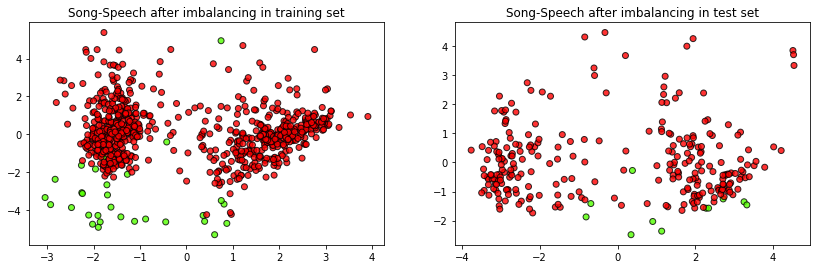

In [181]:
plt.rcParams["figure.figsize"] = (14,9) 
plt.subplot(2,2,1)
plt.scatter(X_train_iso[:, 0], X_train_iso[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.8)
plt.title('Song-Speech after imbalancing in training set')
plt.subplot(2,2,2)
plt.scatter(X_test_iso[:, 0], X_test_iso[:, 1], c=y_test, cmap=plt.cm.prism, edgecolor='k', alpha=0.8)
plt.title('Song-Speech after imbalancing in test set')
plt.show()

## KNN before Undersampling/Oversampling

In [31]:
def Knn(X_train_array, y_train_array, N):   #N è il numero di samples in training test
    
    knn = KNeighborsClassifier()
    
    parameters = {
        'n_neighbors': list(range(2, ceil(N/2))),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'cityblock', 'minkowski']
        }
    
    knn_cv = RandomizedSearchCV(knn,
                     parameters,
                     scoring='f1_macro',
                     cv=10,
                    random_state = 42)
    
    knn_cv.fit(X_train_array, y_train_array)
    
    return knn_cv

In [32]:
knn = Knn(X_train, y_train,779)

In [33]:
print(knn.best_params_)

{'weights': 'uniform', 'n_neighbors': 44, 'metric': 'cityblock'}


In [34]:
y_pred_knn = knn.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       264
           1       1.00      0.27      0.43        11

    accuracy                           0.97       275
   macro avg       0.99      0.64      0.71       275
weighted avg       0.97      0.97      0.96       275



In [36]:
report = classification_report(y_test, y_pred_knn ,  output_dict=True)

In [37]:
new_dic = {}
new_dic['knn'] = {}
new_dic['knn']['precision'] = report['macro avg']['precision']
new_dic['knn']['recall'] = report['macro avg']['recall']
new_dic['knn']['f1-score'] = report['macro avg']['f1-score']
new_dic['knn']['accuracy'] = report['accuracy']

## Decision Tree before Undersampling/Oversampling

In [73]:
def Decision_tree(X_train_array, y_train_array,N):
    
    param_dist = {'max_depth': list(range(2,N)),
              'min_samples_split': [2, N],
              'min_samples_leaf': [ceil(N*0.001), ceil(N*0.02)],
              "criterion": ["gini", "entropy"]}


    tree = DecisionTreeClassifier(random_state=42)


    tree_cv = RandomizedSearchCV(tree, param_dist, cv=10, scoring='f1_macro', random_state=42)


    tree_cv.fit(X_train_array,y_train_array)

    return tree_cv



In [74]:
decision_tree = Decision_tree(X_train, y_train,779)

In [44]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree.best_params_))

Tuned Decision Tree Parameters: {'min_samples_split': 2, 'min_samples_leaf': 16, 'max_depth': 572, 'criterion': 'entropy'}


In [45]:
y_pred_decision_tree = decision_tree.predict(X_test)

In [46]:
print(classification_report(y_test, y_pred_decision_tree))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       264
           1       1.00      0.36      0.53        11

    accuracy                           0.97       275
   macro avg       0.99      0.68      0.76       275
weighted avg       0.98      0.97      0.97       275



In [47]:
report1 = classification_report(y_test, y_pred_decision_tree, output_dict=True)

In [48]:
new_dic['decision_tree'] = {}
new_dic['decision_tree']['precision'] = report1['macro avg']['precision']
new_dic['decision_tree']['recall'] = report1['macro avg']['recall']
new_dic['decision_tree']['f1-score'] = report1['macro avg']['f1-score']
new_dic['decision_tree']['accuracy'] = report['accuracy']

## Logistic Regression before Undersampling/Oversampling

In [83]:
def Logistic_regression(X_train_array, y_train_array):
    params={"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty": ['l1','l2'], 
            'solver': ['liblinear']}

    logreg = LogisticRegression()

    logreg_cv = RandomizedSearchCV(logreg,
                               params,
                               cv=10, 
                               random_state=42,
                               scoring='f1_macro')

    logreg_cv.fit(X_train_array,y_train_array)
                                      
    return logreg_cv

In [84]:
logreg_cv = Logistic_regression(X_train, y_train)

In [51]:
y_pred_logistic = logreg_cv.predict(X_test)

In [52]:
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       264
           1       1.00      0.64      0.78        11

    accuracy                           0.99       275
   macro avg       0.99      0.82      0.89       275
weighted avg       0.99      0.99      0.98       275



In [53]:
report2 = classification_report(y_test, y_pred_logistic, output_dict=True)

In [54]:
new_dic['logistic_regression'] = {}
new_dic['logistic_regression']['precision'] = report2['macro avg']['precision']
new_dic['logistic_regression']['recall'] = report2['macro avg']['recall']
new_dic['logistic_regression']['f1-score'] = report2['macro avg']['f1-score']
new_dic['logistic_regression']['accuracy'] = report2['accuracy']

## Confronto tra i tre modelli prima di Undersampling/Oversampling

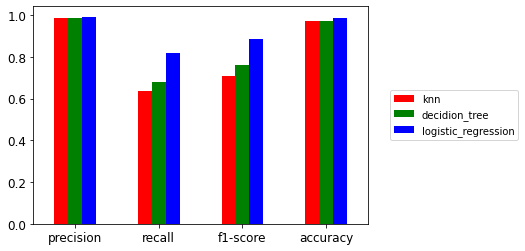

In [55]:
knn = new_dic['knn']

decision_tree = new_dic['decision_tree']

logistic_regression = new_dic['logistic_regression']

index = ['precision', 'recall', 'f1-score', 'accuracy']

df = pd.DataFrame({'knn': knn,
                  'decidion_tree': decision_tree,
                  'logistic_regression': logistic_regression}, index=index)

ax = df.plot.bar(rot=0, color=['r', 'g', 'b'], fontsize = 12)

ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

In [56]:
new_dic

{'knn': {'precision': 0.9852941176470589,
  'recall': 0.6363636363636364,
  'f1-score': 0.7068230277185501,
  'accuracy': 0.9709090909090909},
 'decision_tree': {'precision': 0.9870848708487086,
  'recall': 0.6818181818181819,
  'f1-score': 0.7601246105919003,
  'accuracy': 0.9709090909090909},
 'logistic_regression': {'precision': 0.9925373134328358,
  'recall': 0.8181818181818181,
  'f1-score': 0.8851294903926483,
  'accuracy': 0.9854545454545455}}

## Undersampling

In [57]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours

## Random Undersampling

In [58]:
def randomUnderSampler(X_train_array, y_train_array):
    
    
    rus = RandomUnderSampler(random_state=42, sampling_strategy='majority')
    
    X_res_rus, y_res_rus = rus.fit_resample(X_train_array, y_train_array)
    
    return X_res_rus, y_res_rus

In [59]:
X_res_rus, y_res_rus = randomUnderSampler(X_train, y_train)

In [60]:
print('Resampled dataset shape %s' % Counter(y_res_rus))

Resampled dataset shape Counter({0: 31, 1: 31})


In [61]:
len(X_res_rus)

62

## KNN dopo RandomUndersampling

In [64]:
knn_under_rus = Knn(X_res_rus, y_res_rus, 62)

In [65]:
print(knn_under_rus.best_params_)

{'weights': 'distance', 'n_neighbors': 7, 'metric': 'minkowski'}


In [66]:
y_pred_knn_under_rus = knn_under_rus.predict(X_test)

In [67]:
print(classification_report(y_test, y_pred_knn_under_rus))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       264
           1       1.00      0.91      0.95        11

    accuracy                           1.00       275
   macro avg       1.00      0.95      0.98       275
weighted avg       1.00      1.00      1.00       275



In [70]:
report_under_rus = classification_report(y_test, y_pred_knn_under_rus, output_dict=True)

In [71]:
new_dic_under_rus = {}
new_dic_under_rus['knn'] = {}
new_dic_under_rus['knn']['precision'] = report_under_rus['macro avg']['precision']
new_dic_under_rus['knn']['recall'] = report_under_rus['macro avg']['recall']
new_dic_under_rus['knn']['f1-score'] = report_under_rus['macro avg']['f1-score']
new_dic_under_rus['knn']['accuracy'] = report_under_rus['accuracy']

## Decision Tree dopo RandomUndersampling

In [75]:
decision_tree_under_rus = Decision_tree(X_res_rus, y_res_rus, 62)

In [76]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_under_rus.best_params_))

Tuned Decision Tree Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 45, 'criterion': 'gini'}


In [77]:
y_pred_decision_tree_under_rus = decision_tree_under_rus.predict(X_test)

In [78]:
print(classification_report(y_test, y_pred_decision_tree_under_rus))

              precision    recall  f1-score   support

           0       0.99      0.64      0.77       264
           1       0.09      0.82      0.16        11

    accuracy                           0.64       275
   macro avg       0.54      0.73      0.46       275
weighted avg       0.95      0.64      0.75       275



In [79]:
report1_under_rus = classification_report(y_test, y_pred_decision_tree_under_rus, output_dict=True)

In [80]:
new_dic_under_rus['decision_tree'] = {}
new_dic_under_rus['decision_tree']['precision'] = report1_under_rus['macro avg']['precision']
new_dic_under_rus['decision_tree']['recall'] = report1_under_rus['macro avg']['recall']
new_dic_under_rus['decision_tree']['f1-score'] = report1_under_rus['macro avg']['f1-score']
new_dic_under_rus['decision_tree']['accuracy'] = report_under_rus['accuracy']

## Logistic Regression dopo RandomUndersampling

In [85]:
logreg_cv_under_rus = Logistic_regression(X_res_rus, y_res_rus)

In [86]:
y_pred_logistic_under_rus = logreg_cv_under_rus.predict(X_test)

In [87]:
print(classification_report(y_test, y_pred_logistic_under_rus))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       264
           1       1.00      0.91      0.95        11

    accuracy                           1.00       275
   macro avg       1.00      0.95      0.98       275
weighted avg       1.00      1.00      1.00       275



In [88]:
report2_under_rus = classification_report(y_test,y_pred_logistic_under_rus, output_dict=True)

In [89]:
new_dic_under_rus['logistic_regression'] = {}
new_dic_under_rus['logistic_regression']['precision'] = report2_under_rus['macro avg']['precision']
new_dic_under_rus['logistic_regression']['recall'] = report2_under_rus['macro avg']['recall']
new_dic_under_rus['logistic_regression']['f1-score'] = report2_under_rus['macro avg']['f1-score']
new_dic_under_rus['logistic_regression']['accuracy'] = report2_under_rus['accuracy']

## Confronto tra i tre modelli dopo RandomUndersampling

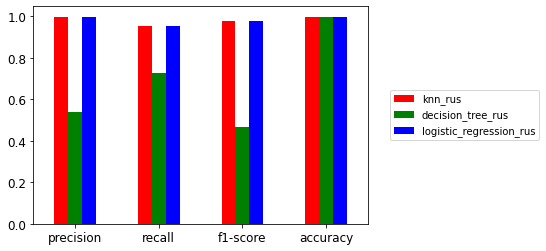

In [90]:
knn_under_rus = new_dic_under_rus['knn']

decision_tree_under_rus = new_dic_under_rus['decision_tree']

logistic_regression_under_rus = new_dic_under_rus['logistic_regression']

index = ['precision', 'recall', 'f1-score', 'accuracy']

df = pd.DataFrame({'knn_rus': knn_under_rus,
                  'decision_tree_rus': decision_tree_under_rus,
                  'logistic_regression_rus': logistic_regression_under_rus}, index=index)

ax = df.plot.bar(rot=0, color=['r', 'g', 'b'], fontsize = 12)

ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## EditedNearestNeighbors

In [91]:
def enn(X_train_array, y_train_array):
    
    enn = EditedNearestNeighbours()
    
    X_res_enn, y_res_enn = enn.fit_resample(X_train_array, y_train_array)
    
    return X_res_enn, y_res_enn

In [92]:
X_res_enn, y_res_enn = enn(X_train, y_train)

In [94]:
print('Resampled dataset shape %s' % Counter(y_res_enn))

Resampled dataset shape Counter({0: 743, 1: 31})


#### Applicazione di t-SNE per fare il grafico di song e speech dopo aver applicato EditedNearestNeighbors

In [183]:
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_res_enn)
X_train_tsne = tsne.fit_transform(X_res_enn)

(774, 2)

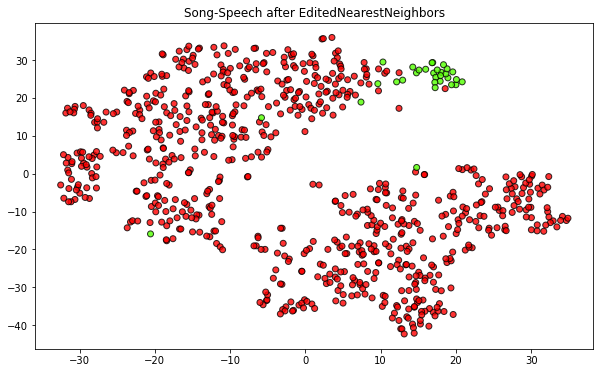

In [188]:
plt.rcParams["figure.figsize"] = (10,6) 
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_res_enn, cmap=plt.cm.prism, edgecolor='k', alpha=0.8)
plt.title('Song-Speech after EditedNearestNeighbors')
plt.show()

## KNN after EditedNearestNeighbors

In [95]:
knn_under_enn = Knn(X_res_enn, y_res_enn, 62)

In [96]:
print(knn_under_enn.best_params_)

{'weights': 'distance', 'n_neighbors': 23, 'metric': 'cityblock'}


In [97]:
y_pred_knn_under_enn = knn_under_enn.predict(X_test)

In [98]:
print(classification_report(y_test, y_pred_knn_under_enn))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       264
           1       1.00      0.36      0.53        11

    accuracy                           0.97       275
   macro avg       0.99      0.68      0.76       275
weighted avg       0.98      0.97      0.97       275



In [99]:
report_under_enn = classification_report(y_test, y_pred_knn_under_enn, output_dict=True)

In [100]:
new_dic_under_enn = {}
new_dic_under_enn['knn'] = {}
new_dic_under_enn['knn']['precision'] = report_under_enn['macro avg']['precision']
new_dic_under_enn['knn']['recall'] = report_under_enn['macro avg']['recall']
new_dic_under_enn['knn']['f1-score'] = report_under_enn['macro avg']['f1-score']
new_dic_under_enn['knn']['accuracy'] = report_under_enn['accuracy']

## Decision Tree after EditedNearestNeighbors

In [101]:
decision_tree_under_enn = Decision_tree(X_res_enn, y_res_enn, 62)

In [102]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_under_enn.best_params_))

Tuned Decision Tree Parameters: {'min_samples_split': 62, 'min_samples_leaf': 2, 'max_depth': 41, 'criterion': 'entropy'}


In [103]:
y_pred_decision_tree_under_enn = decision_tree_under_enn.predict(X_test)

In [104]:
print(classification_report(y_test, y_pred_decision_tree_under_enn))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       264
           1       0.80      0.36      0.50        11

    accuracy                           0.97       275
   macro avg       0.89      0.68      0.74       275
weighted avg       0.97      0.97      0.97       275



In [105]:
report1_under_enn = classification_report(y_test, y_pred_decision_tree_under_enn, output_dict=True)

In [106]:
new_dic_under_enn['decision_tree'] = {}
new_dic_under_enn['decision_tree']['precision'] = report1_under_enn['macro avg']['precision']
new_dic_under_enn['decision_tree']['recall'] = report1_under_enn['macro avg']['recall']
new_dic_under_enn['decision_tree']['f1-score'] = report1_under_enn['macro avg']['f1-score']
new_dic_under_enn['decision_tree']['accuracy'] = report_under_enn['accuracy']

## Logistic Regression after EditedNearestNeighbors

In [107]:
logreg_cv_under_enn = Logistic_regression(X_res_enn, y_res_enn)

In [108]:
y_pred_logistic_under_enn = logreg_cv_under_enn.predict(X_test)

In [109]:
print(classification_report(y_test, y_pred_logistic_under_enn))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       264
           1       1.00      0.55      0.71        11

    accuracy                           0.98       275
   macro avg       0.99      0.77      0.85       275
weighted avg       0.98      0.98      0.98       275



In [110]:
report2_under_enn = classification_report(y_test,y_pred_logistic_under_enn, output_dict=True)

In [111]:
new_dic_under_enn['logistic_regression'] = {}
new_dic_under_enn['logistic_regression']['precision'] = report2_under_enn['macro avg']['precision']
new_dic_under_enn['logistic_regression']['recall'] = report2_under_enn['macro avg']['recall']
new_dic_under_enn['logistic_regression']['f1-score'] = report2_under_enn['macro avg']['f1-score']
new_dic_under_enn['logistic_regression']['accuracy'] = report2_under_enn['accuracy']

## Confronto tra i tre modelli dopo EditedNearestNeighbors

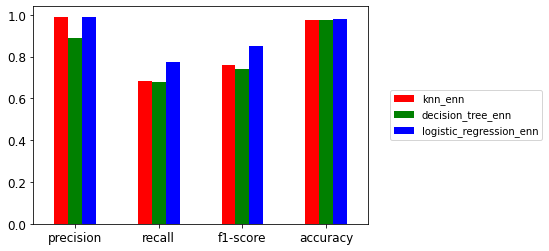

In [112]:
knn_under_enn = new_dic_under_enn['knn']

decision_tree_under_enn = new_dic_under_enn['decision_tree']

logistic_regression_under_enn = new_dic_under_enn['logistic_regression']

index = ['precision', 'recall', 'f1-score', 'accuracy']

df = pd.DataFrame({'knn_enn': knn_under_enn,
                  'decision_tree_enn': decision_tree_under_enn,
                  'logistic_regression_enn': logistic_regression_under_enn}, index=index)

ax = df.plot.bar(rot=0, color=['r', 'g', 'b'], fontsize = 12)

ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## Oversampling

In [113]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

## SMOTE

In [114]:
def smote(X_train_array, y_train_array):
    
    sm = SMOTE(random_state=42)
    
    X_res_sm, y_res_sm = sm.fit_resample(X_train_array, y_train_array)
    
    return X_res_sm, y_res_sm

In [115]:
X_res_sm, y_res_sm = smote(X_train, y_train)

In [116]:
print('Resampled dataset shape %s' % Counter(y_res_sm))

Resampled dataset shape Counter({1: 748, 0: 748})


In [ ]:
#### Applicazione di Multidimensional  per fare il grafico di song e speech dopo aver applicato EditedNearestNeighbors

In [190]:
mds = MDS(n_components=2)
X_train_mds = mds.fit_transform(X_res_sm)
X_train_mds.shape

(1496, 2)

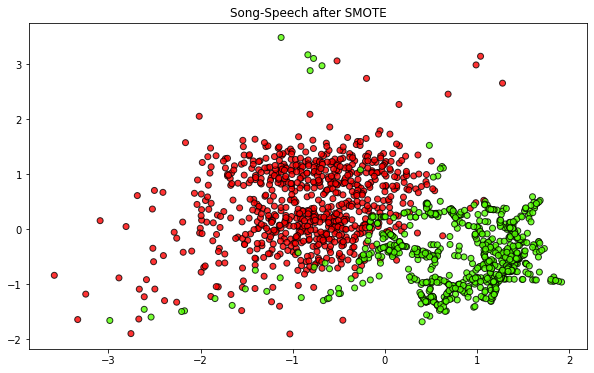

In [192]:
plt.rcParams["figure.figsize"] = (10,6) 
plt.scatter(X_train_mds[:, 0], X_train_mds[:, 1], c=y_res_sm, cmap=plt.cm.prism, edgecolor='k', alpha=0.8)
plt.title('Song-Speech after SMOTE')
plt.show()

## KNN after SMOTE

In [118]:
knn_over_sm = Knn(X_res_sm, y_res_sm, 62)

In [119]:
print(knn_over_sm.best_params_)

{'weights': 'distance', 'n_neighbors': 5, 'metric': 'cityblock'}


In [120]:
y_pred_knn_over_sm = knn_over_sm.predict(X_test)

In [121]:
print(classification_report(y_test, y_pred_knn_over_sm))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       264
           1       0.77      0.91      0.83        11

    accuracy                           0.99       275
   macro avg       0.88      0.95      0.91       275
weighted avg       0.99      0.99      0.99       275



In [122]:
report_over_sm = classification_report(y_test, y_pred_knn_over_sm, output_dict=True)

In [123]:
new_dic_over_sm = {}
new_dic_over_sm['knn'] = {}
new_dic_over_sm['knn']['precision'] = report_over_sm['macro avg']['precision']
new_dic_over_sm['knn']['recall'] = report_over_sm['macro avg']['recall']
new_dic_over_sm['knn']['f1-score'] = report_over_sm['macro avg']['f1-score']
new_dic_over_sm['knn']['accuracy'] = report_over_sm['accuracy']

## Decision Tree after SMOTE

In [124]:
decision_tree_over_sm = Decision_tree(X_res_sm, y_res_sm, 62)

In [125]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_over_sm.best_params_))

Tuned Decision Tree Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 45, 'criterion': 'gini'}


In [126]:
y_pred_decision_tree_over_sm = decision_tree_over_sm.predict(X_test)

In [127]:
print(classification_report(y_test, y_pred_decision_tree_over_sm))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       264
           1       0.57      0.73      0.64        11

    accuracy                           0.97       275
   macro avg       0.78      0.85      0.81       275
weighted avg       0.97      0.97      0.97       275



In [128]:
report1_over_sm = classification_report(y_test, y_pred_decision_tree_over_sm, output_dict=True)

In [129]:
new_dic_over_sm['decision_tree'] = {}
new_dic_over_sm['decision_tree']['precision'] = report1_over_sm['macro avg']['precision']
new_dic_over_sm['decision_tree']['recall'] = report1_over_sm['macro avg']['recall']
new_dic_over_sm['decision_tree']['f1-score'] = report1_over_sm['macro avg']['f1-score']
new_dic_over_sm['decision_tree']['accuracy'] = report_over_sm['accuracy']

## Logistic Regression after SMOTE

In [131]:
logreg_cv_over_sm = Logistic_regression(X_res_sm, y_res_sm)

In [132]:
y_pred_logistic_over_sm = logreg_cv_over_sm.predict(X_test)

In [133]:
print(classification_report(y_test, y_pred_logistic_over_sm))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       264
           1       1.00      0.64      0.78        11

    accuracy                           0.99       275
   macro avg       0.99      0.82      0.89       275
weighted avg       0.99      0.99      0.98       275



In [134]:
report2_over_sm = classification_report(y_test,y_pred_logistic_over_sm, output_dict=True)

In [135]:
new_dic_over_sm['logistic_regression'] = {}
new_dic_over_sm['logistic_regression']['precision'] = report2_over_sm['macro avg']['precision']
new_dic_over_sm['logistic_regression']['recall'] = report2_over_sm['macro avg']['recall']
new_dic_over_sm['logistic_regression']['f1-score'] = report2_over_sm['macro avg']['f1-score']
new_dic_over_sm['logistic_regression']['accuracy'] = report2_over_sm['accuracy']

## Confronto tra i tre modelli dopo SMOTE

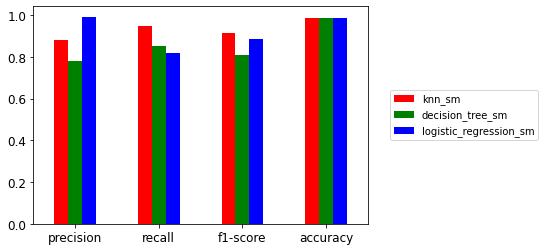

In [136]:
knn_over_sm = new_dic_over_sm['knn']

decision_tree_over_sm = new_dic_over_sm['decision_tree']

logistic_regression_over_sm = new_dic_over_sm['logistic_regression']

index = ['precision', 'recall', 'f1-score', 'accuracy']

df = pd.DataFrame({'knn_sm': knn_over_sm,
                  'decision_tree_sm': decision_tree_over_sm,
                  'logistic_regression_sm': logistic_regression_over_sm}, index=index)

ax = df.plot.bar(rot=0, color=['r', 'g', 'b'], fontsize = 12)

ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## ADASYN

In [137]:
def adasyn(X_train_array, y_train_array):
    
    ada = ADASYN(random_state=42)
    
    X_res_ada, y_res_ada = ada.fit_resample(X_train_array, y_train_array)
    
    return X_res_ada, y_res_ada

In [138]:
X_res_ada, y_res_ada = adasyn(X_train, y_train)

In [139]:
print('Resampled dataset shape %s' % Counter(y_res_sm))

Resampled dataset shape Counter({1: 748, 0: 748})


## KNN after ADASYN

In [140]:
knn_over_ada = Knn(X_res_ada, y_res_ada, 62)

In [141]:
print(knn_over_ada.best_params_)

{'weights': 'distance', 'n_neighbors': 5, 'metric': 'cityblock'}


In [142]:
y_pred_knn_over_ada = knn_over_ada.predict(X_test)

In [143]:
print(classification_report(y_test, y_pred_knn_over_ada))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       264
           1       0.71      0.91      0.80        11

    accuracy                           0.98       275
   macro avg       0.86      0.95      0.90       275
weighted avg       0.98      0.98      0.98       275



In [144]:
report_over_ada = classification_report(y_test, y_pred_knn_over_ada, output_dict=True)

In [146]:
new_dic_over_ada = {}
new_dic_over_ada['knn'] = {}
new_dic_over_ada['knn']['precision'] = report_over_ada['macro avg']['precision']
new_dic_over_ada['knn']['recall'] = report_over_ada['macro avg']['recall']
new_dic_over_ada['knn']['f1-score'] = report_over_ada['macro avg']['f1-score']
new_dic_over_ada['knn']['accuracy'] = report_over_ada['accuracy']

## Decision Tree after ADASYN

In [147]:
decision_tree_over_ada = Decision_tree(X_res_ada, y_res_ada, 62)

In [148]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_over_ada.best_params_))

Tuned Decision Tree Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 9, 'criterion': 'entropy'}


In [149]:
y_pred_decision_tree_over_ada = decision_tree_over_ada.predict(X_test)

In [150]:
print(classification_report(y_test, y_pred_decision_tree_over_sm))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       264
           1       0.57      0.73      0.64        11

    accuracy                           0.97       275
   macro avg       0.78      0.85      0.81       275
weighted avg       0.97      0.97      0.97       275



In [151]:
report1_over_ada = classification_report(y_test, y_pred_decision_tree_over_ada, output_dict=True)

In [152]:
new_dic_over_ada['decision_tree'] = {}
new_dic_over_ada['decision_tree']['precision'] = report1_over_ada['macro avg']['precision']
new_dic_over_ada['decision_tree']['recall'] = report1_over_ada['macro avg']['recall']
new_dic_over_ada['decision_tree']['f1-score'] = report1_over_ada['macro avg']['f1-score']
new_dic_over_ada['decision_tree']['accuracy'] = report_over_ada['accuracy']

## Logistic Regression after ADASYN

In [153]:
logreg_cv_over_ada = Logistic_regression(X_res_ada, y_res_ada)

In [154]:
y_pred_logistic_over_ada = logreg_cv_over_ada.predict(X_test)

In [155]:
print(classification_report(y_test, y_pred_logistic_over_ada))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       264
           1       1.00      0.64      0.78        11

    accuracy                           0.99       275
   macro avg       0.99      0.82      0.89       275
weighted avg       0.99      0.99      0.98       275



In [156]:
report2_over_ada = classification_report(y_test,y_pred_logistic_over_ada, output_dict=True)

In [157]:
new_dic_over_ada['logistic_regression'] = {}
new_dic_over_ada['logistic_regression']['precision'] = report2_over_ada['macro avg']['precision']
new_dic_over_ada['logistic_regression']['recall'] = report2_over_ada['macro avg']['recall']
new_dic_over_ada['logistic_regression']['f1-score'] = report2_over_ada['macro avg']['f1-score']
new_dic_over_ada['logistic_regression']['accuracy'] = report2_over_ada['accuracy']

## Confronto tra i tre modelli dopo ADASYN

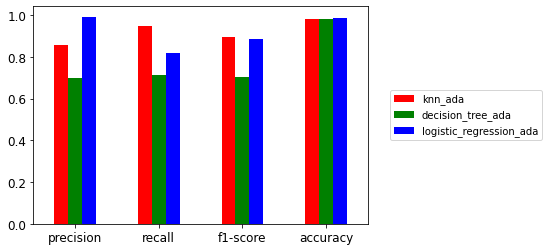

In [158]:
knn_over_ada = new_dic_over_ada['knn']

decision_tree_over_ada = new_dic_over_ada['decision_tree']

logistic_regression_over_ada = new_dic_over_ada['logistic_regression']

index = ['precision', 'recall', 'f1-score', 'accuracy']

df = pd.DataFrame({'knn_ada': knn_over_ada,
                  'decision_tree_ada': decision_tree_over_ada,
                  'logistic_regression_ada': logistic_regression_over_ada}, index=index)

ax = df.plot.bar(rot=0, color=['r', 'g', 'b'], fontsize = 12)

ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))